In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from copy import deepcopy
from scipy.stats import pearsonr
from scipy.spatial.distance import braycurtis
%matplotlib inline

# Plot genera distribution in fMOD

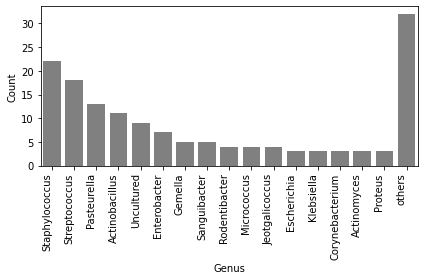

In [2]:
df_db_nr = pd.read_csv("../../databases/fMOMD/fMOMD_info.txt", index_col=0)
fig, ax = plt.subplots(figsize=(6,4))

df_stat = pd.DataFrame.from_dict(dict(Counter(df_db_nr.Genus)), orient="index").sort_values(0, ascending=False).reset_index().rename({'index':'Genus', 0:'Count'}, axis=1)
df_stat2 = df_stat[df_stat.Count>2]
df_stat2 = pd.concat([df_stat2, pd.DataFrame([['others', df_stat[df_stat.Count<=2].Count.sum()]], columns=['Genus','Count'])])
_ = sns.barplot(x="Genus", y="Count", data=df_stat2, ax=ax, color='gray')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("genera_count_in_fMOMD.svg", dpi=600, bbox_inches='tight')

# Validate that the classified oral sequences are present in the oral cavity

## Read metadata

In [3]:
df_meta = pd.read_csv('Theis_mSphere2020_qiime2_output/SraRunTable.txt')[['Run','source_material_ID']]
df_meta.columns = ['SampleID','SampleName']
df_meta = df_meta[df_meta.SampleName.str.contains('Maternal')]
df_meta = df_meta[(df_meta.SampleName.str.contains('Oral')) | (df_meta.SampleName.str.contains('Intestine'))]
df_meta['BodySite'] = [x.split('_')[1] for x in df_meta.SampleName]
df_meta['Mouse'] = [x.split('_')[-1] for x in df_meta.SampleName]
df_meta = df_meta.set_index('SampleID')
df_meta = df_meta[df_meta.BodySite != 'Proximal']
df_meta.head()

,SampleName,BodySite,Mouse
SampleID,,,
SRR10664986,Maternal_Oral_M6,Oral,M6
SRR10664989,Maternal_Oral_M10,Oral,M10
SRR10665002,Maternal_Oral_M5,Oral,M5
SRR10665005,Maternal_Distal_Intestine_M12,Distal,M12
SRR10665009,Maternal_Distal_Intestine_M8,Distal,M8


## Read taxonomy data

In [4]:
df_tax = pd.read_csv('Theis_mSphere2020_qiime2_output/taxonomy.tsv', sep="\t")
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,Feature ID,Taxon,Confidence,LowestTaxonomy
0,ff2be076cf928bdf0eb0935b49878911,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.983031,s__Streptococcus_danieliae
1,95fdd816723ca482a5caba10bea171c8,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999987,g__Lactobacillus
2,b4f3850fd3c56b21b6eb92fc8e4c7087,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.843519,s__Muribacter_muris
3,f80166d86a7f15b69b6ac97505299c3a,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999823,g__Muribaculaceae
4,7f9b6e8f00d7dee79027e94f592ed7d7,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.837048,g__Rodentibacter


## Read count data

In [5]:
df_count = pd.read_csv('Theis_mSphere2020_qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", skiprows=[0], index_col=0)
df_count = df_count.loc[df_tax['Feature ID']].T
df_count = df_count.loc[df_meta.index]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 47032


#OTU ID,ff2be076cf928bdf0eb0935b49878911,95fdd816723ca482a5caba10bea171c8,b4f3850fd3c56b21b6eb92fc8e4c7087,f80166d86a7f15b69b6ac97505299c3a,7f9b6e8f00d7dee79027e94f592ed7d7,e06e73c0550bfd3f63b73915855c10b6,d04b16de2b3bfa84754a4eafcfaec69a,499f1c879aa937fd84ec658999d69c43,4f983ab505c9e0936ecafdda621aead9,8e6f1849d93723676dff6cb1962941a8,...,57e004c428aa50fe1cc37bdc1d46079d,846eb3442b06d98d439a86b95886caea,f16ebdc0f55ee36421412ee28e794539,0c2d1909b9b17f119ed68d167dbf70c1,d1ec9052f7c3fe43ddd5c60db74e478f,2e82f0a6e000d1175398088dd18eec06,442f093e392d58dc3c0831d4ea5354fa,a6f36ae440733e414ff6dc7073f08970,6a488b59170dfe78137f884be500d984,e38bafa6321bd4ed4b15f934c3eb652c
SampleID,,,,,,,,,,,,,,,,,,,,,
SRR10664986,0.516117,0.074481,0.111137,0.008675,0.013948,0.095850,0.002637,0.000489,0.000319,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10664989,0.428259,0.078081,0.053979,0.040268,0.015380,0.121390,0.016713,0.039721,0.006687,0.012085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10665002,0.542537,0.012532,0.000000,0.000000,0.344050,0.083909,0.000021,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10665005,0.000217,0.018508,0.000024,0.097249,0.000000,0.000000,0.066832,0.008965,0.047458,0.028837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10665009,0.000107,0.002261,0.000000,0.048887,0.000000,0.000000,0.035693,0.035645,0.021404,0.057251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compare MOMD and fMOMD

In [6]:
df_blast_MOMD = pd.read_csv("Theis_mSphere2020_qiime2_output/asv-sequences/blast_MOMD/blast_MOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_MOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_blast_fMOMD = pd.read_csv("Theis_mSphere2020_qiime2_output/asv-sequences/blast_fMOMD/blast_fMOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_fMOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

In [19]:
all_mice = set(df_meta.Mouse)
res = []
for mouse in all_mice:
    oral_sample_id = df_meta.loc[(df_meta.Mouse==mouse) & (df_meta.BodySite=='Oral')].index.values
    assert len(oral_sample_id)==1
    oral_sample_id = oral_sample_id[0]
    
    distal_gut_sample_id =  df_meta.loc[(df_meta.Mouse==mouse) & (df_meta.BodySite=='Distal')].index.values
    assert len(distal_gut_sample_id)==1
    distal_gut_sample_id = distal_gut_sample_id[0]
    
    # sequences in oral cavity
    df_oral_seqs = df_relabun.loc[oral_sample_id]
    oral_seqs = list(df_oral_seqs[df_oral_seqs>1e-3].index)
    
    # MOMD
    MOMD_hit = set(df_blast_MOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_MOMD = df_relabun.loc[distal_gut_sample_id, MOMD_hit].sum()
    
    # fMOMD
    fMOMD_hit = set(df_blast_fMOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_fMOMD = df_relabun.loc[distal_gut_sample_id, fMOMD_hit].sum()
    
    # MOMD + overlap with oral sequences
    oral_seqs_w_MOMD_hit = set(oral_seqs).intersection(set(df_blast_MOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_MOMD_overlap = df_relabun.loc[distal_gut_sample_id, oral_seqs_w_MOMD_hit].sum()
        
    # fMOMD + overlap with oral sequences
    oral_seqs_w_fMOMD_hit = set(oral_seqs).intersection(set(df_blast_fMOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_fMOMD_overlap = df_relabun.loc[distal_gut_sample_id, oral_seqs_w_fMOMD_hit].sum()
    
    res.append([mouse, distal_gut_sample_id,oral_frac_MOMD, oral_frac_MOMD_overlap, oral_frac_fMOMD, oral_frac_fMOMD_overlap])
df_res = pd.DataFrame(res, columns=['Mouse','SampleID','MOMD','MOMD_OVL','fMOMD','fMOMD_OVL']).set_index('SampleID')
df_res['FractionInOralSample'] = df_res['fMOMD_OVL']/df_res['fMOMD']
df_res.head()

,Mouse,MOMD,MOMD_OVL,fMOMD,fMOMD_OVL,FractionInOralSample
SampleID,,,,,,
SRR10665180,M7,0.061565,0.042829,0.042751,0.042751,1.000000
SRR10665005,M12,0.096431,0.027690,0.027971,0.027498,0.983085
SRR10665157,M15,0.107024,0.052307,0.052231,0.052110,0.997678
SRR10665144,M9,0.041261,0.009108,0.009322,0.009108,0.977020
SRR10665179,M4,0.119163,0.053617,0.053944,0.053473,0.991276


In [20]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex=True, sharey=True)

# _ = sns.scatterplot(x="MOMD", y="MOMD_OVL", data=df_res, ax=ax[0], s=196, color='gray')
# corr = pearsonr(df_res.MOMD, df_res.MOMD_OVL)[0]
# bc_dissim = braycurtis(df_res.MOMD, df_res.MOMD_OVL)
# _ = ax[0].plot([-0.02,0.22],[-0.02,0.22],'k--',zorder=-5)
# _ = ax[0].set_xlim([-0.02,0.22])
# _ = ax[0].set_ylim([-0.02,0.22])
# _ = ax[0].set_title('r = %2.2f, bc = %2.2f'% (corr, bc_dissim))
# _ = ax[0].set_ylabel('fMOMD_OVL')

# _ = sns.scatterplot(x="fMOMD", y="fMOMD_OVL", data=df_res, ax=ax[1], s=196, color='gray')
# corr = pearsonr(df_res.fMOMD, df_res.fMOMD_OVL)[0]
# bc_dissim = braycurtis(df_res.fMOMD, df_res.fMOMD_OVL)
# _ = ax[1].plot([-0.02,0.22],[-0.02,0.22],'k--',zorder=-5)
# _ = ax[1].set_xlim([-0.02,0.22])
# _ = ax[1].set_ylim([-0.02,0.22])
# _ = ax[1].set_title('r = %2.2f, bc = %2.2f'% (corr, bc_dissim))
# _ = ax[1].set_ylabel('fMOMD_OVL')

# plt.tight_layout()
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("comp_MOMD_fMOMD.svg", dpi=600, bbox_inches='tight')

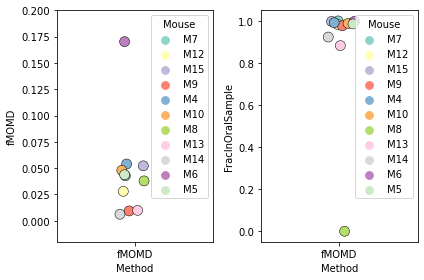

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4))

# oral bacterial fraction
df2plot = deepcopy(df_res)
df2plot['FracInOralSample'] = df2plot['fMOMD_OVL']/df2plot['fMOMD']
df2plot['Method'] = 'fMOMD'
df2plot.loc[df2plot.fMOMD == 0, 'fMOMD'] = 1e-5
_ = sns.stripplot(x="Method", y="fMOMD", data=df2plot, ax=ax[0], s=10, edgecolor='k', linewidth=0.5, palette='Set3', jitter=True, hue='Mouse')
_ = ax[0].set_ylim([-0.02,0.2])

# percentage of fraction present in the oral cavity
df2plot = df2plot[df2plot.fMOMD > 1e-5]
_ = sns.stripplot(x="Method", y="FracInOralSample", data=df2plot, ax=ax[1], s=10, edgecolor='k', linewidth=0.5, palette='Set3', jitter=True, hue='Mouse')
_ = ax[1].set_ylim([-0.05,1.05])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("fMOMD_oral_bacteria_fraction_in_stool.svg", dpi=600, bbox_inches='tight')

In [22]:
df_res.fMOMD.mean()

0.04564714241710199